This is voice recognition using the CNN. Dataset here I have used of VoxCeleb which has diversity of emotions in the sound. Below code is meant to mount  data in the colab.

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Load the path and filename into the local variable by traversing to each sub-folder
import os
from fnmatch import fnmatch
root = '/content/drive/My Drive/Colab Notebooks/aac' 
pattern = "*.m4a"
m4a_files =[os.path.join(path,name) for path,subdirs,files in os.walk(root) for name in files if fnmatch(name,pattern)]


In [0]:
#Get the speakers name through List Comprehension
speakers = [fname.split('/')[6] for fname in m4a_files]

In [0]:
#Get unique list of speakers from the dataset 
import numpy as np
def unique(list1): 
    x = np.array(list1) 
    return(np.unique(x)) 
l = unique(speakers)
q=l.tolist()


In [7]:
#Create the dataframe to club speakers and files
import pandas as pd
data = pd.DataFrame({'Speaker':speakers,'filename':m4a_files})
data.head()

,Speaker,filename
0,id08911,/content/drive/My Drive/Colab Notebooks/aac/id...
1,id08911,/content/drive/My Drive/Colab Notebooks/aac/id...
2,id08911,/content/drive/My Drive/Colab Notebooks/aac/id...
3,id08911,/content/drive/My Drive/Colab Notebooks/aac/id...
4,id08911,/content/drive/My Drive/Colab Notebooks/aac/id...


In [8]:
#Group by the data to check how much number of voice samples each speaker has. 
#For e.g., the speaker id08911 has the 97 voice samples 
d=data.groupby('Speaker').size()
d['id08911']

97

As per the Chase Roberts it is true that:

1. The code never crashes, raises an exception, or even slows down.
2. The network still trains and the loss will still go down.
3. The values converge after a few hours, but to really poor results

So limit the data set for training, validation and test set I used below code where I can test my different size of data

In [0]:
trainFiles = []
testSpeakers =[]
for spk in q:
  num_files = d[spk]
  count = 0
  for file in m4a_files:
    if file.find(spk)!= -1:
      count += 1
      if((count > 0 and count <= round(num_files*0.35))): #or (count>round(num_files*0.04) and count<= round(num_files*0.06)) or (count>round(num_files*0.08) and count<= round(num_files*0.1)) or (count>round(num_files*0.12) and count<= round(num_files*0.14)) or (count>round(num_files*0.16) and count<= round(num_files*0.18))):
        trainFiles.append(file)
        trainSpeakers.append(spk)
      else:
        break
    else:
      if count!=0:
        break

Now let us look at audio samples how they look alike and sound alike. To do this I have plotted a graph and to hear a sound that should look alike 

In [0]:
#Loading the audio file
import librosa
data, sampling_rate = librosa.load(trainFiles[0])

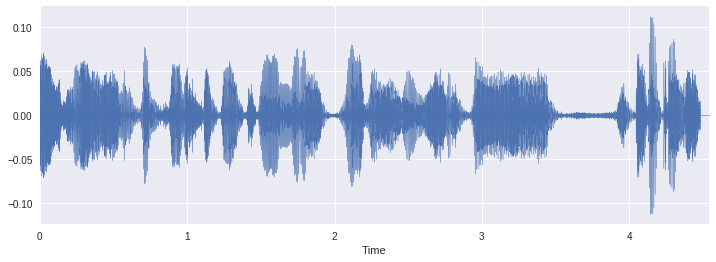

In [43]:
#Plotting the audio file
import matplotlib.pyplot as plt
import librosa.display
import glob 

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [44]:
#To hear the audio file
import IPython.display as ipd
ipd.Audio(trainFiles[0])

In [45]:
#Now as i get the filenames and speakers I club lists into a dataframe and see first 5 elements
trainData = pd.DataFrame({'Speaker':trainSpeakers,'filename':trainFiles})
trainData.head()

,Speaker,filename
0,id00017,/content/drive/My Drive/Colab Notebooks/aac/id...
1,id00017,/content/drive/My Drive/Colab Notebooks/aac/id...
2,id00017,/content/drive/My Drive/Colab Notebooks/aac/id...
3,id00017,/content/drive/My Drive/Colab Notebooks/aac/id...
4,id00017,/content/drive/My Drive/Colab Notebooks/aac/id...


In [15]:
#To check number of files we are going to have for model to train and test.
len(trainFiles)

9137

In [46]:
#As I need the numbers which will be provided to me by MFCC's I pick only MFCC's for training 
def parser(row):
   # function to load files and extract features
   file_name = row.filename
   print(trainData[trainData['filename']==file_name].index.item(),'/',len(trainFiles),'   ','Completion % ',round((trainData[trainData['filename']==file_name].index.item()/len(trainFiles))*100))
   # handle exception to check if there isn't a file which is corrupted
   try:
      # here kaiser_fast is a technique used for faster extraction
      X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
      # we extract mfcc feature from data
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=48).T,axis=0) 
   except Exception as e:
      print("Error encountered while parsing file: ", file)
      return None, None
 
   feature = mfccs
   label = row.Speaker
 
   return [feature, label]
count = 0
trainFeature = trainData.apply(parser, axis=1)
trainFeature.columns = ['feature', 'label']

#Note: Below will take time in extracting the MFCC's

0 / 12793     Completion %  0
0 / 12793     Completion %  0
1 / 12793     Completion %  0
2 / 12793     Completion %  0
3 / 12793     Completion %  0
4 / 12793     Completion %  0
5 / 12793     Completion %  0
6 / 12793     Completion %  0
7 / 12793     Completion %  0
8 / 12793     Completion %  0
9 / 12793     Completion %  0
10 / 12793     Completion %  0
11 / 12793     Completion %  0
12 / 12793     Completion %  0
13 / 12793     Completion %  0
14 / 12793     Completion %  0
15 / 12793     Completion %  0
16 / 12793     Completion %  0
17 / 12793     Completion %  0
18 / 12793     Completion %  0
19 / 12793     Completion %  0
20 / 12793     Completion %  0
21 / 12793     Completion %  0
22 / 12793     Completion %  0
23 / 12793     Completion %  0
24 / 12793     Completion %  0
25 / 12793     Completion %  0
26 / 12793     Completion %  0
27 / 12793     Completion %  0
28 / 12793     Completion %  0
29 / 12793     Completion %  0
30 / 12793     Completion %  0
31 / 12793     Comp

In [0]:
#As there are few files which may have encountered the error will have None as the entry to avoid it below is the code
tnData=[]
X1 = trainFeature.feature.tolist()
for i in X1:
  if not(i is None):
    tnData.append(i)

In [85]:
#To train our data we need to shape our input 
X = np.array(tnData)
train_X = X.reshape(-1,1, 48, 1)
train_X.shape


(12669, 1, 48, 1)

In [0]:
#Converting data type to float 
train_X = train_X.astype('float32')


In [0]:
#For label data removing unnecessary Nones
tnyData=[]
y1 = trainFeature.label.tolist()
for i in y1:
  if not(i is None):
    tnyData.append(i)

In [0]:
#Converting into the numpy array
train_y = np.array(tnyData)

In [0]:
#Splitting data into train, validation and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, test_size=0.35, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.35, random_state=42)

In [0]:
#Doing the one hot encoding with the y output to identify which user
from sklearn.preprocessing import LabelEncoder
import keras
import keras.utils
from keras import utils as np_utils
lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))



In [102]:
#Here I have size of the train, test and validation set respectively
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(5352, 1, 48, 1) (5352, 118)
(4435, 1, 48, 1) (4435, 118)
(2882, 1, 48, 1) (2882, 118)


In [0]:
#Importing the packages to implement CNN
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU


In [0]:
#Setting the hyper parameters of Network
batch_size = 50
epochs = 20
num_classes = y_train.shape[1]

In [0]:
#Creating CNN model which describes about how different layers are shaped with inputs, outputs, kernel size, activation 
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),activation='linear',input_shape=(1,48,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(256, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [0]:
#Setting network parameters to describe the loss after feed forward and for gradient descent the optimizer used.
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [105]:
#Now its about training our model with train and validation data set
train = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_val,y_val))

Instructions for updating:
Use tf.cast instead.
Train on 5352 samples, validate on 2882 samples
Epoch 1/20
5352/5352 [==============================] - 7s 1ms/step - loss: 4.2504 - acc: 0.0788 - val_loss: 3.9028 - val_acc: 0.1260
Epoch 2/20
5352/5352 [==============================] - 1s 263us/step - loss: 2.9261 - acc: 0.2993 - val_loss: 2.7131 - val_acc: 0.3574
Epoch 3/20
5352/5352 [==============================] - 1s 264us/step - loss: 1.8302 - acc: 0.5402 - val_loss: 1.9726 - val_acc: 0.5045
Epoch 4/20
5352/5352 [==============================] - 1s 264us/step - loss: 1.2058 - acc: 0.6796 - val_loss: 1.6392 - val_acc: 0.6031
Epoch 5/20
5352/5352 [==============================] - 1s 264us/step - loss: 0.8188 - acc: 0.7805 - val_loss: 1.3963 - val_acc: 0.6645
Epoch 6/20
5352/5352 [==============================] - 1s 262us/step - loss: 0.4462 - acc: 0.8771 - val_loss: 1.3722 - val_acc: 0.6898
Epoch 7/20
5352/5352 [==============================] - 1s 263us/step - loss: 0.2543 - acc

In [0]:
#Below is multiperceptron model currently which I do not prefer for training the data
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

num_labels = train_y.shape[1]
filter_size = 2

# build model
model = Sequential()

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [0]:
model.fit(X1, y1, batch_size=32, epochs=15)

Epoch 1/15
3620/3620 [==============================] - 1s 301us/step - loss: 15.8794 - acc: 0.0102
Epoch 2/15
3620/3620 [==============================] - 1s 168us/step - loss: 15.8964 - acc: 0.0113
Epoch 3/15
3620/3620 [==============================] - 1s 182us/step - loss: 15.8848 - acc: 0.0135
Epoch 4/15
3620/3620 [==============================] - 1s 179us/step - loss: 15.8974 - acc: 0.0135
Epoch 5/15
3620/3620 [==============================] - 1s 183us/step - loss: 15.8955 - acc: 0.0138
Epoch 6/15
3620/3620 [==============================] - 1s 182us/step - loss: 15.8955 - acc: 0.0138
Epoch 7/15
3620/3620 [==============================] - 1s 180us/step - loss: 15.8955 - acc: 0.0138
Epoch 8/15
3620/3620 [==============================] - 1s 185us/step - loss: 15.8955 - acc: 0.0138
Epoch 9/15
3620/3620 [==============================] - 1s 180us/step - loss: 15.8955 - acc: 0.0138
Epoch 10/15
3620/3620 [==============================] - 1s 181us/step - loss: 15.8955 - acc: 0.0138

In [108]:
#Evaluating the model
test_eval = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', test_eval[1])

Test accuracy: 0.7386696731493196


In [0]:
#print('Test loss:', test_eval[0])

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


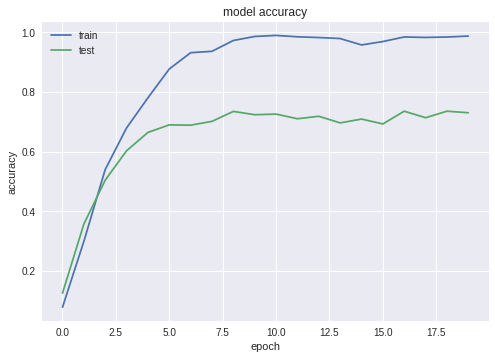

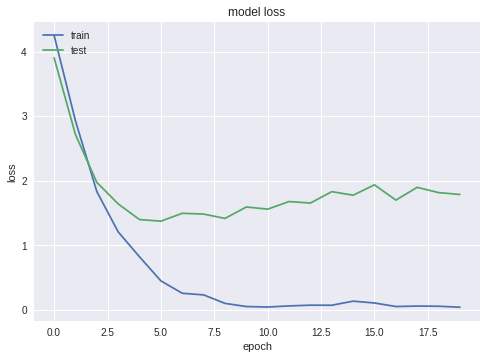

In [111]:
import matplotlib.pyplot as plt
print(train.history.keys())
# summarize history for accuracy
plt.plot(train.history['acc'])
plt.plot(train.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()